In [98]:
import numpy as np
import pandas as pd
from models import *
from priors_new import *
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [99]:
model_prior = GaussianMixture(latent_dim=1, num_clusters=5)
model_encoder = build_encoder(dim_x=100, h_dim=64, n_layers=2)
model_decoder = build_decoder(dim_x=100, latent_dim=1, h_dim=64, n_layers=2)
model = VariationalAutoencoder(encoder=model_encoder, enc_out_dim=64, decoder=model_decoder, prior=model_prior)

In [100]:
@torch.no_grad()
def generate_clustered_gauss_1d(
    n_clusters: int = 4,
    points_per_cluster: int = 300,
    n_features: int = 100,
    latent_dim: int = 1,          # 1D latent space
    sigma_val: float = 0.5,       # observation noise std for Gaussian in feature space
    cluster_centers=None,         # if None, auto-generate
    cluster_spread: float = 0.2,  # smaller => tighter clusters in latent space
    seed: int = 42,
    device: str = "cpu",
):
    """
    Build a clean clusterable dataset with 1D latent space:
      z | c ~ N(center[c], cluster_spread^2) in R^latent_dim
      x | z ~ N(W z + b, sigma^2 I) in R^{n_features}
    Returns:
      X [N, D] (float), labels [N] (long), true Z [N, latent_dim], centers [K, latent_dim]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # Set cluster centers in latent space (R^{latent_dim})
    if cluster_centers is None:
        # Evenly spaced along the first latent axis; zeros elsewhere if latent_dim>1
        centers_1d = torch.linspace(-2, 2, n_clusters, device=device)
        centers = torch.zeros(n_clusters, latent_dim, device=device)
        centers[:, 0] = centers_1d
    else:
        centers = torch.as_tensor(cluster_centers, dtype=torch.float32, device=device)
        if centers.ndim == 1:
            centers = centers.unsqueeze(1)  # [K,1] if given as list of scalars
        assert centers.shape == (n_clusters, latent_dim), \
            f"centers must be shape ({n_clusters},{latent_dim})"

    # Cluster assignments
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]

    # Latent samples
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]  # shift by cluster centers

    # Linear map to feature space
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    mean_x = z @ W.T + b  # [N, D]

    # Gaussian observation noise (isotropic)
    if sigma_val <= 0:
        X = mean_x
    else:
        X = mean_x + sigma_val * torch.randn(mean_x.shape, device=mean_x.device, generator=g)

    return X, labels.to(device), z.to(device), centers.to(device), W,b

In [101]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")
torch.manual_seed(42)

# Generate simulated dataset with 1D latent space
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1

# Define cluster centers in 1D
cluster_centers = [-2.0, -0.75, 0.75, 2.0] 
X, y, Z_true, true_centers, W,b = generate_clustered_gauss_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    sigma_val=0.5,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,  # Tight clusters
    seed=42,
    device=device
)
print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Points per cluster: {points_per_cluster}")

Using device: mps
Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  Number of clusters: 4
  Points per cluster: 300


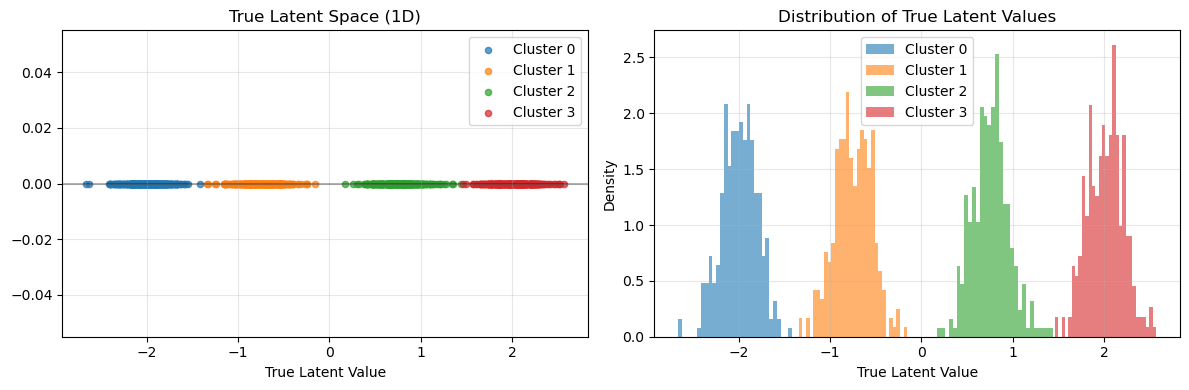

In [102]:
# Visualize the true latent space
plt.figure(figsize=(12, 4))

# Plot 1: True latent values colored by cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0].to("cpu"), np.zeros_like(Z_true[mask, 0].to("cpu")), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space (1D)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of true latent values by cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0].to("cpu"), bins=30, alpha=0.6, label=f'Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('Distribution of True Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [103]:
dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

In [104]:
model.to(device)
model.prior.to(device)

GaussianMixture()

In [105]:
# Import additional libraries for GMM analysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, accuracy_score
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
import warnings
warnings.filterwarnings('ignore')


In [106]:
def calculate_mixture_proportion_comparison(gmm, cluster_assignments, true_labels, n_components):
    """
    Compare GMM mixture proportions with actual cluster proportions.
    
    Parameters:
    - gmm: Fitted GMM model
    - cluster_assignments: GMM cluster assignments
    - true_labels: True cluster labels
    - n_components: Number of GMM components
    
    Returns:
    - dict with mixture proportion comparison metrics
    """
    try:
        # Get GMM mixture proportions (weights)
        gmm_proportions = gmm.weights_
        
        # Calculate actual cluster proportions
        cluster_counts = np.bincount(true_labels.astype(int))
        cluster_proportions = cluster_counts / np.sum(cluster_counts)
        
        # Pad cluster_proportions if it has fewer components than GMM
        if len(cluster_proportions) < n_components:
            padded_cluster = np.zeros(n_components)
            padded_cluster[:len(cluster_proportions)] = cluster_proportions
            cluster_proportions = padded_cluster
        elif len(cluster_proportions) > n_components:
            # Truncate if cluster has more components
            cluster_proportions = cluster_proportions[:n_components]
            cluster_proportions = cluster_proportions / np.sum(cluster_proportions)
        
        # Calculate Jensen-Shannon Divergence (symmetric version of KL divergence)
        js_divergence = jensenshannon(gmm_proportions, cluster_proportions)
        
        # Calculate KL Divergence (GMM -> Cluster)
        kl_divergence = entropy(gmm_proportions, cluster_proportions)
        
        # Calculate KL Divergence (Cluster -> GMM) for symmetry
        kl_divergence_reverse = entropy(cluster_proportions, gmm_proportions)
        
        # Calculate correlation between proportions
        correlation = np.corrcoef(gmm_proportions, cluster_proportions)[0, 1]
        
        # Calculate mean absolute error
        mae = np.mean(np.abs(gmm_proportions - cluster_proportions))
        
        # Calculate root mean square error
        rmse = np.sqrt(np.mean((gmm_proportions - cluster_proportions) ** 2))
        
        return {
            'js_divergence': js_divergence,
            'kl_divergence_gmm_to_cluster': kl_divergence,
            'kl_divergence_cluster_to_gmm': kl_divergence_reverse,
            'proportion_correlation': correlation,
            'proportion_mae': mae,
            'proportion_rmse': rmse,
            'gmm_proportions': gmm_proportions.tolist(),
            'cluster_proportions': cluster_proportions.tolist()
        }
        
    except Exception as e:
        print(f"Error calculating mixture proportion comparison: {e}")
        return {
            'js_divergence': np.nan,
            'kl_divergence_gmm_to_cluster': np.nan,
            'kl_divergence_cluster_to_gmm': np.nan,
            'proportion_correlation': np.nan,
            'proportion_mae': np.nan,
            'proportion_rmse': np.nan,
            'gmm_proportions': [],
            'cluster_proportions': []
        }


In [107]:
def fit_gmm_and_analyze(latent_data, true_labels, n_components, model_name="unknown"):
    """
    Fit GMM to latent data and calculate various metrics.
    
    Parameters:
    - latent_data: numpy array of latent embeddings
    - true_labels: true cluster labels
    - n_components: number of GMM components
    - model_name: name of the model for logging
    
    Returns:
    - dict with GMM metrics
    """
    try:
        # Ensure we have enough data points for the number of components
        if len(latent_data) < n_components:
            print(f"Warning: Not enough data points ({len(latent_data)}) for {n_components} components in {model_name}")
            return None
        
        # Fit GMM
        gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=200)
        gmm.fit(latent_data)
        
        # Get probabilities for each data point
        probabilities = gmm.predict_proba(latent_data)  # shape: (n_samples, n_components)
        
        # Calculate entropy for each data point
        point_entropies = [entropy(probs) for probs in probabilities]
        
        # Calculate max probability to cluster for each data point
        max_probabilities = np.max(probabilities, axis=1)
        
        # Calculate goodness of fit metrics
        bic = gmm.bic(latent_data)
        aic = gmm.aic(latent_data)
        
        # Calculate additional goodness of fit metrics
        log_likelihood = gmm.score(latent_data)
        perplexity = np.exp(-log_likelihood / len(latent_data))
        
        # Get cluster assignments
        cluster_assignments = gmm.predict(latent_data)
        
        # Calculate silhouette score
        if len(set(cluster_assignments)) > 1:  # Need at least 2 clusters for silhouette
            silhouette = silhouette_score(latent_data, cluster_assignments)
        else:
            silhouette = np.nan
        
        # Calculate Calinski-Harabasz index
        if len(set(cluster_assignments)) > 1:
            calinski_harabasz = calinski_harabasz_score(latent_data, cluster_assignments)
        else:
            calinski_harabasz = np.nan
        
        # Calculate Davies-Bouldin index
        if len(set(cluster_assignments)) > 1:
            davies_bouldin = davies_bouldin_score(latent_data, cluster_assignments)
        else:
            davies_bouldin = np.nan
        
        # Calculate ARI with true labels
        ari_with_true = adjusted_rand_score(cluster_assignments, true_labels)
        
        # Calculate mixture proportion comparison
        mixture_proportion_metrics = calculate_mixture_proportion_comparison(
            gmm, cluster_assignments, true_labels, n_components
        )
        
        # Calculate distribution statistics for entropy
        entropy_stats = {
            'mean_entropy': np.mean(point_entropies),
            'std_entropy': np.std(point_entropies),
            'min_entropy': np.min(point_entropies),
            'max_entropy': np.max(point_entropies),
            'median_entropy': np.median(point_entropies)
        }
        
        # Calculate distribution statistics for max probabilities
        max_prob_stats = {
            'mean_max_prob': np.mean(max_probabilities),
            'std_max_prob': np.std(max_probabilities),
            'min_max_prob': np.min(max_probabilities),
            'max_max_prob': np.max(max_probabilities),
            'median_max_prob': np.median(max_probabilities)
        }
        
        return {
            'n_components': n_components,
            'n_samples': len(latent_data),
            'bic': bic,
            'aic': aic,
            'log_likelihood': log_likelihood,
            'perplexity': perplexity,
            'silhouette_score': silhouette,
            'calinski_harabasz': calinski_harabasz,
            'davies_bouldin': davies_bouldin,
            'ari_with_true': ari_with_true,
            'converged': gmm.converged_,
            'n_iter': gmm.n_iter_,
            **entropy_stats,
            **max_prob_stats,
            **mixture_proportion_metrics
        }
        
    except Exception as e:
        print(f"Error fitting GMM for {model_name}: {e}")
        return None


In [108]:
# Train the VAE model with early stopping
print("Training VAE model...")
model.train()
epochs, kl_warm = 500, 50
losses_history = []

# Early stopping parameters
patience = 100  # Number of epochs to wait for improvement
min_delta = 1e-4  # Minimum change to qualify as an improvement
best_loss = float('inf')
patience_counter = 0
early_stop = False

for epoch in range(1, epochs+1):
    kl_w = 1
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        xb = xb.to(device).float()
        loss,_ = model.variational_inference_step(xb, opt)
        losses={"loss":loss}
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    losses_history.append(epoch_losses)
    
    current_loss = tot/n
    
    # Early stopping check
    if current_loss < best_loss - min_delta:
        best_loss = current_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch == 1 or epoch % 20 == 0 or epoch == epochs:
        print(f"[{epoch:03d}] loss={current_loss:.3f} (best: {best_loss:.3f}, patience: {patience_counter}/{patience})")
    
    # Check for early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch} (patience: {patience})")
        early_stop = True
        break

if not early_stop:
    print("Training completed!")
else:
    print(f"Training stopped early at epoch {epoch}")

print(f"Final loss: {current_loss:.4f}, Best loss: {best_loss:.4f}")
print(f"Total epochs: {epoch}")


Training VAE model...
[001] loss=5936.838 (best: 5936.838, patience: 0/100)


ValueError: Expected parameter loc (Tensor of shape (128, 1)) of distribution Normal(loc: torch.Size([128, 1]), scale: torch.Size([128, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='mps:0', grad_fn=<SliceBackward0>)

In [109]:
print("Extracting learned latent representations...")
model.eval()
with torch.no_grad():
    # Get the variational posterior q(z|x)
    qz_x = model._define_variational_family(X.float().to(device))
    
    # Get the mean (mu_q) and sample from the distribution
    mu_q = qz_x.mean  # Mean of q(z|x)
    Z_learned = qz_x.sample()  # Sample from q(z|x) - this is what we want for GMM analysis
    
    # Convert to numpy
    mu_learned = mu_q.detach().flatten().to("cpu").numpy()
    Z_learned = Z_learned.detach().flatten().to("cpu").numpy()
    
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

print(f"Learned latent (sampled) shape: {Z_learned.shape}")
print(f"Learned latent (sampled) range: [{Z_learned.min():.3f}, {Z_learned.max():.3f}]")
print(f"Learned latent (mean) shape: {mu_learned.shape}")
print(f"Learned latent (mean) range: [{mu_learned.min():.3f}, {mu_learned.max():.3f}]")

# --- plot comparison ---
plt.figure(figsize=(14, 4))

# Plot 1: Mean of variational posterior
plt.subplot(1, 2, 1)
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(mu_learned[sel], bins=50, alpha=0.5, label=str(lab))
plt.xlabel("mu_q (mean of q(z|x))")
plt.ylabel("Frequency")
plt.title("Histogram of mu_q by label")
plt.legend(title="y")
plt.grid(True, alpha=0.3)

# Plot 2: Sampled latent values
plt.subplot(1, 2, 2)
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(Z_learned[sel], bins=50, alpha=0.5, label=str(lab))
plt.xlabel("Z_learned (sampled from q(z|x))")
plt.ylabel("Frequency")
plt.title("Histogram of Z_learned by label")
plt.legend(title="y")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Extracting learned latent representations...


ValueError: Expected parameter loc (Tensor of shape (1200, 1)) of distribution Normal(loc: torch.Size([1200, 1]), scale: torch.Size([1200, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='mps:0')

In [110]:
# Perform GMM analysis on true latent space
print("Analyzing GMM on true latent space...")
true_gmm_results = fit_gmm_and_analyze(
    Z_true.cpu().numpy(), 
    y.cpu().numpy(), 
    n_clusters, 
    "True_Latent"
)

if true_gmm_results:
    print("True Latent GMM Results:")
    for key, value in true_gmm_results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
else:
    print("Failed to analyze true latent space")


Analyzing GMM on true latent space...
True Latent GMM Results:
  n_components: 4
  n_samples: 1200
  bic: 2920.1217
  aic: 2864.130859375
  log_likelihood: -1.1842211484909058
  perplexity: 1.0009872913360596
  silhouette_score: 0.8077
  calinski_harabasz: 23353.9590
  davies_bouldin: 0.2550
  ari_with_true: 0.9978
  converged: True
  n_iter: 2
  mean_entropy: 0.00360387796536088
  std_entropy: 0.03881974145770073
  min_entropy: 1.7479577040331655e-16
  max_entropy: 0.645520806312561
  median_entropy: 1.0753791457318584e-07
  mean_max_prob: 0.998653769493103
  std_max_prob: 0.017186392098665237
  min_max_prob: 0.6530773639678955
  max_max_prob: 1.0
  median_max_prob: 1.0
  js_divergence: 0.0013
  kl_divergence_gmm_to_cluster: 0.0000
  kl_divergence_cluster_to_gmm: 0.0000
  proportion_correlation: nan
  proportion_mae: 0.0007
  proportion_rmse: 0.0009
  gmm_proportions: [0.24982742965221405, 0.25123804807662964, 0.25017252564430237, 0.24876198172569275]
  cluster_proportions: [0.25, 0.2

In [111]:
# Perform GMM analysis on learned latent space
Z_learned = Z_learned.reshape(-1, 1)
print("Analyzing GMM on learned latent space...")
learned_gmm_results = fit_gmm_and_analyze(
    Z_learned, 
    y.cpu().numpy(), 
    n_clusters, 
    "Learned_Latent"
)

if learned_gmm_results:
    print("Learned Latent GMM Results:")
    for key, value in learned_gmm_results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
else:
    print("Failed to analyze learned latent space")


Analyzing GMM on learned latent space...
Learned Latent GMM Results:
  n_components: 4
  n_samples: 1200
  bic: 9194.4889
  aic: 9138.498046875
  log_likelihood: -3.7985408306121826
  perplexity: 1.0031704902648926
  silhouette_score: 0.7840
  calinski_harabasz: 17292.3789
  davies_bouldin: 0.3984
  ari_with_true: 0.6298
  converged: True
  n_iter: 4
  mean_entropy: 0.09270496666431427
  std_entropy: 0.1947140246629715
  min_entropy: 8.332312015035341e-29
  max_entropy: 0.6947094798088074
  median_entropy: 5.179161234991625e-05
  mean_max_prob: 0.9586825370788574
  std_max_prob: 0.10156247764825821
  min_max_prob: 0.5003179311752319
  max_max_prob: 1.0
  median_max_prob: 0.9999961853027344
  js_divergence: 0.2101
  kl_divergence_gmm_to_cluster: 0.1785
  kl_divergence_cluster_to_gmm: 0.1829
  proportion_correlation: nan
  proportion_mae: 0.1257
  proportion_rmse: 0.1544
  gmm_proportions: [0.10228530317544937, 0.2509751319885254, 0.1462612897157669, 0.5004782676696777]
  cluster_proport

In [90]:
# Create comparison table
if true_gmm_results and learned_gmm_results:
    print("\n" + "="*80)
    print("GMM ANALYSIS COMPARISON")
    print("="*80)
    
    # Create comparison DataFrame
    comparison_data = []
    for metric in ['bic', 'aic', 'log_likelihood', 'perplexity', 'silhouette_score', 
                   'calinski_harabasz', 'davies_bouldin', 'ari_with_true', 
                   'mean_entropy', 'mean_max_prob', 'js_divergence', 
                   'proportion_correlation', 'proportion_mae']:
        if metric in true_gmm_results and metric in learned_gmm_results:
            comparison_data.append({
                'Metric': metric,
                'True_Latent': true_gmm_results[metric],
                'Learned_Latent': learned_gmm_results[metric],
                'Difference': learned_gmm_results[metric] - true_gmm_results[metric]
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False, float_format='%.4f'))
    correlation = np.corrcoef(Z_true.cpu(), Z_learned)[0, 1]
    
    # Summary statistics
    print(f"\nSUMMARY:")
    print(f"  True latent correlation with learned: {correlation:.4f}")
    print(f"  True latent ARI: {true_gmm_results.get('ari_with_true', 'N/A'):.4f}")
    print(f"  Learned latent ARI: {learned_gmm_results.get('ari_with_true', 'N/A'):.4f}")
    print(f"  True latent silhouette: {true_gmm_results.get('silhouette_score', 'N/A'):.4f}")
    print(f"  Learned latent silhouette: {learned_gmm_results.get('silhouette_score', 'N/A'):.4f}")
    
    # Save results to CSV
    comparison_df.to_csv('gmm_comparison_simulation.csv', index=False)
    print(f"\nResults saved to: gmm_comparison_simulation.csv")
else:
    print("Could not create comparison - missing results")



GMM ANALYSIS COMPARISON
                Metric  True_Latent  Learned_Latent  Difference
                   bic    2920.1217       9194.4889   6274.3672
                   aic    2864.1309       9138.4980   6274.3672
        log_likelihood      -1.1842         -3.7985     -2.6143
            perplexity       1.0010          1.0032      0.0022
      silhouette_score       0.8077          0.7840     -0.0237
     calinski_harabasz   23353.9590      17292.3789  -6061.5801
        davies_bouldin       0.2550          0.3984      0.1434
         ari_with_true       0.9978          0.6298     -0.3679
          mean_entropy       0.0036          0.0927      0.0891
         mean_max_prob       0.9987          0.9587     -0.0400
         js_divergence       0.0013          0.2101      0.2089
proportion_correlation          NaN             NaN         NaN
        proportion_mae       0.0007          0.1257      0.1250

SUMMARY:
  True latent correlation with learned: nan
  True latent ARI: 0.9978

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

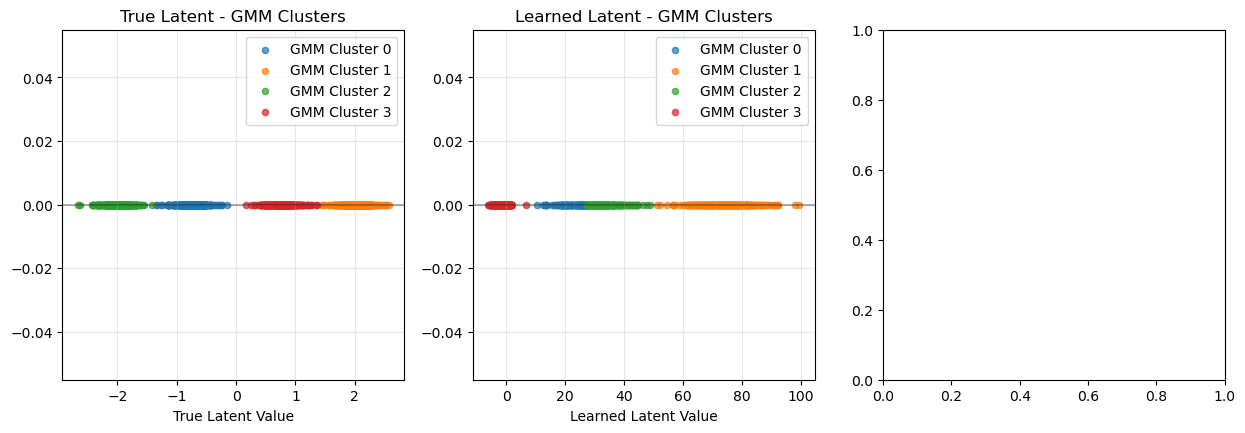

In [91]:
# Visualize GMM clustering results
Z_true = Z_true.cpu()
if learned_gmm_results:
    # Fit GMM to learned latent space for visualization
    gmm_learned = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_learned.fit(Z_learned)
    learned_cluster_assignments = gmm_learned.predict(Z_learned)
    learned_probabilities = gmm_learned.predict_proba(Z_learned)
    
    # Fit GMM to true latent space for visualization
    gmm_true = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_true.fit(Z_true.numpy())
    true_cluster_assignments = gmm_true.predict(Z_true.numpy())
    true_probabilities = gmm_true.predict_proba(Z_true.numpy())
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: True latent with GMM clusters
    plt.subplot(2, 3, 1)
    for i in range(n_clusters):
        mask = true_cluster_assignments == i
        plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
                   c=[plt.cm.tab10(i)], label=f'GMM Cluster {i}', alpha=0.7, s=20)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('True Latent Value')
    plt.title('True Latent - GMM Clusters')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Learned latent with GMM clusters
    plt.subplot(2, 3, 2)
    for i in range(n_clusters):
        mask = learned_cluster_assignments == i
        plt.scatter(Z_learned[mask, 0], np.zeros_like(Z_learned[mask, 0]), 
                   c=[plt.cm.tab10(i)], label=f'GMM Cluster {i}', alpha=0.7, s=20)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Learned Latent Value')
    plt.title('Learned Latent - GMM Clusters')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: True latent with true clusters
    plt.subplot(2, 3, 3)
    for i in range(n_clusters):
        mask = y == i
        plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
                   c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('True Latent Value')
    plt.title('True Latent - True Clusters')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Entropy distribution for learned latent
    plt.subplot(2, 3, 4)
    learned_entropies = [entropy(probs) for probs in learned_probabilities]
    plt.hist(learned_entropies, bins=30, alpha=0.7, color='blue', label='Learned')
    plt.xlabel('Entropy')
    plt.ylabel('Count')
    plt.title('Entropy Distribution - Learned')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Entropy distribution for true latent
    plt.subplot(2, 3, 5)
    true_entropies = [entropy(probs) for probs in true_probabilities]
    plt.hist(true_entropies, bins=30, alpha=0.7, color='red', label='True')
    plt.xlabel('Entropy')
    plt.ylabel('Count')
    plt.title('Entropy Distribution - True')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Max probability distribution
    plt.subplot(2, 3, 6)
    learned_max_probs = np.max(learned_probabilities, axis=1)
    true_max_probs = np.max(true_probabilities, axis=1)
    plt.hist(learned_max_probs, bins=30, alpha=0.7, color='blue', label='Learned', density=True)
    plt.hist(true_max_probs, bins=30, alpha=0.7, color='red', label='True', density=True)
    plt.xlabel('Max Probability')
    plt.ylabel('Density')
    plt.title('Max Probability Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print(f"\nAdditional Statistics:")
    print(f"  Learned entropy - Mean: {np.mean(learned_entropies):.4f}, Std: {np.std(learned_entropies):.4f}")
    print(f"  True entropy - Mean: {np.mean(true_entropies):.4f}, Std: {np.std(true_entropies):.4f}")
    print(f"  Learned max prob - Mean: {np.mean(learned_max_probs):.4f}, Std: {np.std(learned_max_probs):.4f}")
    print(f"  True max prob - Mean: {np.mean(true_max_probs):.4f}, Std: {np.std(true_max_probs):.4f}")
else:
    print("Could not visualize GMM results - missing learned_gmm_results")


In [ ]:
# Save detailed results
if true_gmm_results and learned_gmm_results:
    # Create detailed results DataFrame
    detailed_results = []
    
    # Add true latent results
    true_results = true_gmm_results.copy()
    true_results['latent_type'] = 'true'
    detailed_results.append(true_results)
    
    # Add learned latent results
    learned_results = learned_gmm_results.copy()
    learned_results['latent_type'] = 'learned'
    detailed_results.append(learned_results)
    
    # Create DataFrame and save
    detailed_df = pd.DataFrame(detailed_results)
    detailed_df.to_csv('detailed_gmm_results_simulation.csv', index=False)
    print(f"Detailed results saved to: detailed_gmm_results_simulation.csv")
    
    # Print final summary
    print(f"\n" + "="*80)
    print("FINAL SUMMARY")
    print("="*80)
    print(f"Dataset: {n_clusters} clusters, {points_per_cluster} points per cluster")
    print(f"Total samples: {len(Z_true)}")
    print(f"True cluster centers: {true_centers.flatten().tolist()}")
    print(f"Correlation between true and learned latent: {correlation:.4f}")
    print(f"Training converged: {learned_gmm_results.get('converged', 'N/A')}")
    print(f"GMM iterations: {learned_gmm_results.get('n_iter', 'N/A')}")
    
    # Key metrics comparison
    print(f"\nKey Metrics Comparison:")
    print(f"  ARI (True): {true_gmm_results.get('ari_with_true', 'N/A'):.4f}")
    print(f"  ARI (Learned): {learned_gmm_results.get('ari_with_true', 'N/A'):.4f}")
    print(f"  Silhouette (True): {true_gmm_results.get('silhouette_score', 'N/A'):.4f}")
    print(f"  Silhouette (Learned): {learned_gmm_results.get('silhouette_score', 'N/A'):.4f}")
    print(f"  BIC (True): {true_gmm_results.get('bic', 'N/A'):.2f}")
    print(f"  BIC (Learned): {learned_gmm_results.get('bic', 'N/A'):.2f}")
    print(f"  JS Divergence (True): {true_gmm_results.get('js_divergence', 'N/A'):.4f}")
    print(f"  JS Divergence (Learned): {learned_gmm_results.get('js_divergence', 'N/A'):.4f}")
    
    print(f"\nFiles saved:")
    print(f"  - gmm_comparison_simulation.csv")
    print(f"  - detailed_gmm_results_simulation.csv")
else:
    print("Could not save detailed results - missing GMM analysis results")


Detailed results saved to: detailed_gmm_results_simulation.csv

FINAL SUMMARY
Dataset: 4 clusters, 300 points per cluster
Total samples: 1200
True cluster centers: [-2.0, -0.75, 0.75, 2.0]
Correlation between true and learned latent: nan
Training converged: True
GMM iterations: 4

Key Metrics Comparison:
  ARI (True): 0.9978
  ARI (Learned): 0.6299
  Silhouette (True): 0.8077
  Silhouette (Learned): 0.7958
  BIC (True): 2920.12
  BIC (Learned): 8446.45
  JS Divergence (True): 0.0013
  JS Divergence (Learned): 0.2103

Files saved:
  - gmm_comparison_simulation.csv
  - detailed_gmm_results_simulation.csv


In [112]:
def evaluate_gmmvae_probabilities(model, X, true_labels):
    model.eval()
    with torch.no_grad():
        cluster_probs = model.cluster_probabilities(X)
        
        # Get predicted cluster assignments
        predicted_labels = torch.argmax(cluster_probs, dim=1)
        
        # Calculate metrics
        ari = adjusted_rand_score(true_labels, predicted_labels.numpy())
        accuracy = (predicted_labels == true_labels).float().mean()
        
        # Entropy of predictions (uncertainty measure)
        entropy = -torch.sum(cluster_probs * torch.log(cluster_probs + 1e-8), dim=1)
        mean_entropy = entropy.mean()
        
        return {
            'cluster_probs': cluster_probs,
            'predicted_labels': predicted_labels,
            'ari': ari,
            'accuracy': accuracy,
            'mean_entropy': mean_entropy
        }
def calculate_probability_metrics(probs, true_labels):
    """Calculate comprehensive probability-based metrics"""
    
    predicted_labels = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    
    metrics = {
        'accuracy': accuracy_score(true_labels, predicted_labels),
        'ari': adjusted_rand_score(true_labels, predicted_labels),
        'mean_confidence': np.mean(max_probs),
        'std_confidence': np.std(max_probs),
        'mean_entropy': np.mean(entropy),
        'std_entropy': np.std(entropy),
        'min_confidence': np.min(max_probs),
        'max_confidence': np.max(max_probs),
        'uncertain_predictions': np.sum(max_probs < 0.5),  # Low confidence predictions
        'confident_predictions': np.sum(max_probs > 0.8)   # High confidence predictions
    }
    
    return metrics

In [118]:
model.prior.cluster_probabilities(samples=X)

NotImplementedError: 

In [113]:
vae_results = evaluate_gmmvae_probabilities(model, X, y)
vae_metrics = calculate_probability_metrics(vae_results['cluster_probs'], y)

print(f"VAE Metrics: {vae_metrics}")


NotImplementedError: 